# Assignment 2
## Experiment 1

In [5]:
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from keras import backend as K

from time import time

Using TensorFlow backend.


## Importing data

In [7]:
train_images = pickle.load( open( "../imagenet-200/train_images.pkl", "rb" ) )
train_labels = pickle.load( open( "../imagenet-200/train_labels.pkl", "rb" ) )
val_images = pickle.load( open( "../imagenet-200/val_images.pkl", "rb" ) )
val_labels = pickle.load( open( "../imagenet-200/val_labels.pkl", "rb" ) )
y_train = pickle.load( open( "../imagenet-200/y_train.pkl", "rb" ) )
y_test = pickle.load( open( "../imagenet-200/y_test.pkl", "rb" ) )

In [8]:
text_labels = pd.read_csv('../imagenet-200/map_clsloc.txt', sep='\s', header=None, engine='python')
text_labels.columns=['label', 'id', 'description']
text_labels.head()

,label,id,description
0,n02119789,1,kit_fox
1,n02100735,2,English_setter
2,n02110185,3,Siberian_husky
3,n02096294,4,Australian_terrier
4,n02102040,5,English_springer


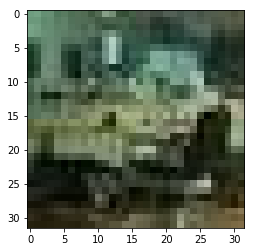

704    barbershop
Name: description, dtype: object


In [9]:
plotData = train_images[0]
plt.imshow(plotData)
plt.show()
print(text_labels.loc[text_labels['label']==train_labels[0], 'description'])

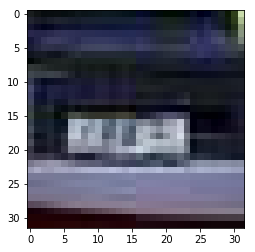

547    cash_machine
Name: description, dtype: object


In [10]:
plotData = val_images[0]
plt.imshow(plotData)
plt.show()
print(text_labels.loc[text_labels['label']==val_labels[0], 'description'])

In [11]:
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
train_images /= 255
val_images /= 255


In [49]:
y_train = []
y_test = []
for row in train_labels:
    label = text_labels.loc[text_labels['label']==row]['id'].iloc[0]
    y_train.append(label)

for row in val_labels:
    label = text_labels.loc[text_labels['label']==row]['id'].iloc[0]
    y_test.append(label)
    
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [50]:

enc = OneHotEncoder(categories='auto')
y_train = enc.fit_transform(train_labels.reshape(-1, 1)).toarray()
y_test = enc.transform(val_labels.reshape(-1, 1)).toarray()


In [51]:
enc.categories_

[array(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640',
        'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750',
        'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289',
        'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695',
        'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620',
        'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799',
        'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165',
        'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429',
        'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972',
        'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003',
        'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495',
        'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196',
        'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148',
        'n02791270', 'n02793495', 'n02795169', 'n02

In [52]:
pickle.dump(y_train, open( "../imagenet-200/y_train.pkl", "wb" ) )
pickle.dump(y_test, open( "../imagenet-200/y_test.pkl", "wb" ) )

In [53]:
pickle.dump(enc, open( "../imagenet-200/encoder.pkl", "wb" ) )

### Shuffle the training data

In [12]:
train_images, train_labels, y_train = shuffle(train_images, train_labels, y_train, random_state=41)

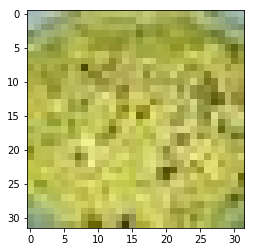

         label   id description
812  n07583066  813   guacamole


In [13]:
plotData = train_images[0]
plt.imshow(plotData)
plt.show()
print(text_labels.loc[text_labels['label']==train_labels[0]])

## Experiment 1: Keras CNN

In [14]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Optimizers
First we will select an optimizer for the task. We will start with a smaller number of epochs to eliminate any that are obviously poor choices.

In [57]:

opts = [('SGD', SGD()), ('RMSprop', RMSprop()), ('Adagrad', Adagrad()), ('Adadelta', Adadelta()), 
        ('Adam', Adam()), ('Adamax', Adamax()), ('Nadam', Nadam())]

batch_size = 32
num_classes = 200
epochs = 50

num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')


for name, opt in opts:
    print('Training ' + name + ' optimizer')
    logs = "logs/optimizer/"+name
    tensorboard = TensorBoard(log_dir=logs)
    
    model_name = name + '_keras_imagenet200_base.h5'
    
    model_base = Sequential()
    model_base.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=train_images.shape[1:]))
    model_base.add(Activation('relu'))
    model_base.add(Conv2D(32, (3, 3)))
    model_base.add(Activation('relu'))
    model_base.add(MaxPooling2D(pool_size=(2, 2)))
    model_base.add(Dropout(0.25))

    model_base.add(Conv2D(64, (3, 3), padding='same'))
    model_base.add(Activation('relu'))
    model_base.add(Conv2D(64, (3, 3)))
    model_base.add(Activation('relu'))
    model_base.add(MaxPooling2D(pool_size=(2, 2)))
    model_base.add(Dropout(0.25))

    model_base.add(Flatten())
    model_base.add(Dense(512))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(0.5))
    model_base.add(Dense(num_classes))
    model_base.add(Activation('softmax'))
    
    # Let's train the model using RMSprop
    model_base.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    start = time()

    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    # Fit the model on the batches generated by datagen.flow().
    model_base.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                                     epochs=epochs,
                                     validation_data=(val_images, y_test),
                                     workers=4,
                                     steps_per_epoch=len(train_images)/batch_size, 
                                     callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model_base.save(model_path)

    # Score trained model.
    scores = model_base.evaluate(val_images, y_test, verbose=1)

    end = time()
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))



Training SGD optimizer
Epoch 1/50
3125/3125 [==============================] - 25s 8ms/step - loss: 5.2982 - acc: 0.0052 - val_loss: 5.2933 - val_acc: 0.0059
Epoch 2/50
3125/3125 [==============================] - 25s 8ms/step - loss: 5.2358 - acc: 0.0096 - val_loss: 5.1405 - val_acc: 0.0113
Epoch 3/50
3125/3125 [==============================] - 25s 8ms/step - loss: 5.1478 - acc: 0.0128 - val_loss: 5.0788 - val_acc: 0.0182
Epoch 4/50
3125/3125 [==============================] - 25s 8ms/step - loss: 5.0939 - acc: 0.0174 - val_loss: 4.9952 - val_acc: 0.0296
Epoch 5/50
3125/3125 [==============================] - 25s 8ms/step - loss: 5.0258 - acc: 0.0234 - val_loss: 4.8967 - val_acc: 0.0385
Epoch 6/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.9411 - acc: 0.0317 - val_loss: 4.7850 - val_acc: 0.0496
Epoch 7/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8614 - acc: 0.0387 - val_loss: 4.7128 - val_acc: 0.0599
Epoch 8/50
3125/3125 [==========

Epoch 10/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8314 - acc: 0.0474 - val_loss: 4.7025 - val_acc: 0.0573
Epoch 11/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8661 - acc: 0.0446 - val_loss: 4.7488 - val_acc: 0.0515
Epoch 12/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8788 - acc: 0.0425 - val_loss: 4.7716 - val_acc: 0.0485
Epoch 13/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8849 - acc: 0.0404 - val_loss: 4.9086 - val_acc: 0.0411
Epoch 14/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8923 - acc: 0.0406 - val_loss: 5.0777 - val_acc: 0.0388
Epoch 15/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8887 - acc: 0.0394 - val_loss: 4.7517 - val_acc: 0.0524
Epoch 16/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8673 - acc: 0.0411 - val_loss: 4.7493 - val_acc: 0.0458
Epoch 17/50
3125/3125 [=========================

3125/3125 [==============================] - 25s 8ms/step - loss: 4.1299 - acc: 0.1305 - val_loss: 4.1555 - val_acc: 0.1255
Epoch 20/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.1236 - acc: 0.1308 - val_loss: 4.1778 - val_acc: 0.1226
Epoch 21/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.1100 - acc: 0.1333 - val_loss: 4.2052 - val_acc: 0.1174
Epoch 22/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.0985 - acc: 0.1342 - val_loss: 4.1471 - val_acc: 0.1253
Epoch 23/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.0925 - acc: 0.1353 - val_loss: 4.1496 - val_acc: 0.1262
Epoch 24/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.0845 - acc: 0.1360 - val_loss: 4.1684 - val_acc: 0.1223
Epoch 25/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.0747 - acc: 0.1369 - val_loss: 4.1530 - val_acc: 0.1237
Epoch 26/50
3125/3125 [==============================] - 25s

3125/3125 [==============================] - 25s 8ms/step - loss: 4.2731 - acc: 0.1097 - val_loss: 4.3932 - val_acc: 0.0956
Epoch 38/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2579 - acc: 0.1112 - val_loss: 4.3234 - val_acc: 0.1040
Epoch 39/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2640 - acc: 0.1125 - val_loss: 4.4533 - val_acc: 0.0902
Epoch 40/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2662 - acc: 0.1137 - val_loss: 4.1907 - val_acc: 0.1185
Epoch 41/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2662 - acc: 0.1123 - val_loss: 4.2816 - val_acc: 0.1116
Epoch 42/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2613 - acc: 0.1114 - val_loss: 4.3101 - val_acc: 0.1063
Epoch 43/50
3125/3125 [==============================] - 25s 8ms/step - loss: 4.2611 - acc: 0.1119 - val_loss: 4.2204 - val_acc: 0.1166
Epoch 44/50
3125/3125 [==============================] - 25s

In [11]:
opts = [('SGD', SGD()), ('Adamax', Adamax())]

batch_size = 32
num_classes = 200
epochs = 100

num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')


for name, opt in opts:
    print('Training ' + name + ' optimizer')
    logs = "logs/optimizer/100/"+name
    tensorboard = TensorBoard(log_dir=logs)
    
    model_name = name + '_100_keras_imagenet200_base.h5'
    
    model_base = Sequential()
    model_base.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=train_images.shape[1:]))
    model_base.add(Activation('relu'))
    model_base.add(Conv2D(32, (3, 3)))
    model_base.add(Activation('relu'))
    model_base.add(MaxPooling2D(pool_size=(2, 2)))
    model_base.add(Dropout(0.25))

    model_base.add(Conv2D(64, (3, 3), padding='same'))
    model_base.add(Activation('relu'))
    model_base.add(Conv2D(64, (3, 3)))
    model_base.add(Activation('relu'))
    model_base.add(MaxPooling2D(pool_size=(2, 2)))
    model_base.add(Dropout(0.25))

    model_base.add(Flatten())
    model_base.add(Dense(512))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(0.5))
    model_base.add(Dense(num_classes))
    model_base.add(Activation('softmax'))
    
    # Let's train the model using RMSprop
    model_base.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    start = time()

    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    # Fit the model on the batches generated by datagen.flow().
    model_base.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                                     epochs=epochs,
                                     validation_data=(val_images, y_test),
                                     workers=4,
                                     steps_per_epoch=len(train_images)/batch_size, 
                                     callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model_base.save(model_path)

    # Score trained model.
    scores = model_base.evaluate(val_images, y_test, verbose=1)

    end = time()
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))



Training SGD optimizer
Epoch 1/100
3125/3125 [==============================] - 26s 8ms/step - loss: 5.2978 - acc: 0.0048 - val_loss: 5.2914 - val_acc: 0.0053
Epoch 2/100
3125/3125 [==============================] - 25s 8ms/step - loss: 5.2566 - acc: 0.0070 - val_loss: 5.2114 - val_acc: 0.0113
Epoch 3/100
3125/3125 [==============================] - 25s 8ms/step - loss: 5.1814 - acc: 0.0107 - val_loss: 5.1011 - val_acc: 0.0162
Epoch 4/100
3125/3125 [==============================] - 25s 8ms/step - loss: 5.1120 - acc: 0.0160 - val_loss: 5.0289 - val_acc: 0.0247
Epoch 5/100
3125/3125 [==============================] - 25s 8ms/step - loss: 5.0430 - acc: 0.0225 - val_loss: 4.9140 - val_acc: 0.0413
Epoch 6/100
3125/3125 [==============================] - 25s 8ms/step - loss: 4.9505 - acc: 0.0305 - val_loss: 4.7935 - val_acc: 0.0493
Epoch 7/100
3125/3125 [==============================] - 25s 8ms/step - loss: 4.8572 - acc: 0.0385 - val_loss: 4.6980 - val_acc: 0.0610
Epoch 8/100
3125/3125 [==

Epoch 61/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8347 - acc: 0.1702 - val_loss: 3.9722 - val_acc: 0.1563
Epoch 62/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8319 - acc: 0.1726 - val_loss: 3.8830 - val_acc: 0.1672
Epoch 63/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8224 - acc: 0.1729 - val_loss: 3.9292 - val_acc: 0.1556
Epoch 64/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8196 - acc: 0.1738 - val_loss: 3.9330 - val_acc: 0.1590
Epoch 65/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8114 - acc: 0.1730 - val_loss: 3.9807 - val_acc: 0.1548
Epoch 66/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.8100 - acc: 0.1739 - val_loss: 3.9770 - val_acc: 0.1522
Epoch 67/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7995 - acc: 0.1750 - val_loss: 3.9320 - val_acc: 0.1594
Epoch 68/100
3125/3125 [=================

Epoch 79/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7080 - acc: 0.1926 - val_loss: 3.9969 - val_acc: 0.1618
Epoch 80/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7064 - acc: 0.1939 - val_loss: 3.9885 - val_acc: 0.1655
Epoch 81/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7044 - acc: 0.1917 - val_loss: 3.9069 - val_acc: 0.1779
Epoch 82/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7050 - acc: 0.1929 - val_loss: 3.8028 - val_acc: 0.1826
Epoch 83/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.6972 - acc: 0.1929 - val_loss: 3.9967 - val_acc: 0.1696
Epoch 84/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7009 - acc: 0.1936 - val_loss: 3.8741 - val_acc: 0.1747
Epoch 85/100
3125/3125 [==============================] - 25s 8ms/step - loss: 3.7062 - acc: 0.1946 - val_loss: 3.8964 - val_acc: 0.1763
Epoch 86/100
3125/3125 [=================

## Experiment 2: CIFAR 100 Starting Code
https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100#the-model

In [12]:
epochs = 200
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/1"
tensorboard = TensorBoard(log_dir=logs)

model_name = 'keras_imagenet200_100base.h5'

#start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

Epoch 1/200
1563/1562 [==============================] - 37s 23ms/step - loss: 4.8993 - acc: 0.0435 - val_loss: 4.4843 - val_acc: 0.0967
Epoch 2/200
1563/1562 [==============================] - 33s 21ms/step - loss: 4.5560 - acc: 0.0845 - val_loss: 4.1693 - val_acc: 0.1394
Epoch 3/200
1563/1562 [==============================] - 33s 21ms/step - loss: 4.4113 - acc: 0.1047 - val_loss: 4.0295 - val_acc: 0.1616
Epoch 4/200
1563/1562 [==============================] - 33s 21ms/step - loss: 4.3023 - acc: 0.1209 - val_loss: 3.9087 - val_acc: 0.1765
Epoch 5/200
1563/1562 [==============================] - 33s 21ms/step - loss: 4.2180 - acc: 0.1355 - val_loss: 3.8326 - val_acc: 0.1934
Epoch 6/200
1563/1562 [==============================] - 33s 21ms/step - loss: 4.1376 - acc: 0.1467 - val_loss: 3.6963 - val_acc: 0.2128
Epoch 7/200
1563/1562 [==============================] - 34s 21ms/step - loss: 4.0630 - acc: 0.1575 - val_loss: 3.7248 - val_acc: 0.2086
Epoch 8/200
1563/1562 [==================

1563/1562 [==============================] - 34s 21ms/step - loss: 3.7792 - acc: 0.2462 - val_loss: 3.4144 - val_acc: 0.2934
Epoch 120/200
1563/1562 [==============================] - 34s 22ms/step - loss: 3.7724 - acc: 0.2445 - val_loss: 3.5115 - val_acc: 0.2794
Epoch 121/200
1563/1562 [==============================] - 34s 21ms/step - loss: 3.7684 - acc: 0.2453 - val_loss: 3.3796 - val_acc: 0.3017
Epoch 122/200
1563/1562 [==============================] - 34s 21ms/step - loss: 3.7820 - acc: 0.2445 - val_loss: 3.3505 - val_acc: 0.2980
Epoch 123/200
1563/1562 [==============================] - 34s 22ms/step - loss: 3.7716 - acc: 0.2445 - val_loss: 3.4555 - val_acc: 0.2848
Epoch 124/200
1563/1562 [==============================] - 34s 22ms/step - loss: 3.7699 - acc: 0.2448 - val_loss: 3.4234 - val_acc: 0.2915
Epoch 125/200
1563/1562 [==============================] - 34s 22ms/step - loss: 3.7854 - acc: 0.2409 - val_loss: 3.5029 - val_acc: 0.2809
Epoch 126/200
1563/1562 [================

1563/1562 [==============================] - 34s 22ms/step - loss: 4.0219 - acc: 0.2105 - val_loss: 3.5772 - val_acc: 0.2700
Epoch 179/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.0367 - acc: 0.2084 - val_loss: 3.5627 - val_acc: 0.2705
Epoch 180/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.0551 - acc: 0.2096 - val_loss: 3.5709 - val_acc: 0.2755
Epoch 181/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.1054 - acc: 0.2045 - val_loss: 3.7939 - val_acc: 0.2733
Epoch 182/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.0745 - acc: 0.2052 - val_loss: 3.5694 - val_acc: 0.2693
Epoch 183/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.0852 - acc: 0.2032 - val_loss: 3.5907 - val_acc: 0.2688
Epoch 184/200
1563/1562 [==============================] - 34s 22ms/step - loss: 4.0839 - acc: 0.2036 - val_loss: 3.5897 - val_acc: 0.2704
Epoch 185/200
1563/1562 [================

NameError: name 'model_base' is not defined

In [14]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
#print('Runtime:', str(end-start))


10000/10000 [==============================] - 2s 207us/step
Test loss: 3.834818507385254
Test accuracy: 0.2278


In [17]:
opts = [('SGD', SGD()), ('RMSprop', RMSprop(lr=0.0001, decay=1e-6)), ('Adagrad', Adagrad()), ('Adadelta', Adadelta()), 
        ('Adam', Adam()), ('Adamax', Adamax()), ('Nadam', Nadam())]

for name, opt in opts:
    
    print('Training ' + name + 'optimizer')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = 64

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/opt_100/" + name
    tensorboard = TensorBoard(log_dir=logs)

    model_name = name+'keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()
    
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))
    
    print('\n\n')


Training SGDoptimizer
Epoch 1/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.1734 - acc: 0.0143 - val_loss: 4.9637 - val_acc: 0.0378
Epoch 2/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.9299 - acc: 0.0366 - val_loss: 4.7335 - val_acc: 0.0667
Epoch 3/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.7553 - acc: 0.0574 - val_loss: 4.5957 - val_acc: 0.0786
Epoch 4/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.6016 - acc: 0.0736 - val_loss: 4.3902 - val_acc: 0.1015
Epoch 5/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.4454 - acc: 0.0919 - val_loss: 4.1839 - val_acc: 0.1312
Epoch 6/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.3163 - acc: 0.1087 - val_loss: 4.1917 - val_acc: 0.1282
Epoch 7/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.2085 - acc: 0.1221 - val_loss: 4.0011 - val_acc: 0.1534
Epoch 8/50
1563/1562 [====

1563/1562 [==============================] - 33s 21ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 18/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 19/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 20/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 21/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0374 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 22/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 23/50
1563/1562 [==============================] - 33s 21ms/step - loss: 16.0374 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 24/50
1563/1562 [================

1563/1562 [==============================] - 35s 22ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 23/50
1563/1562 [==============================] - 35s 23ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 24/50
1563/1562 [==============================] - 35s 23ms/step - loss: 16.0374 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 25/50
1563/1562 [==============================] - 35s 23ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 26/50
1563/1562 [==============================] - 35s 22ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 27/50
1563/1562 [==============================] - 35s 23ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 28/50
1563/1562 [==============================] - 35s 22ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 29/50
1563/1562 [================

1563/1562 [==============================] - 37s 24ms/step - loss: 16.0375 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.00506.0115 - - ETA: 26s - loss: 16.0303 - acc: 0. - ETA: 25s - loss: 16.0317 - acc: 0.00 - ETA: 25s - loss: 16.0317 - acc - ETA: 25s - loss: 16.0347 - acc: 0.0 - ETA: 25s - loss: 16.0353 - acc: 0.005 - ETA: 24s - loss: 16.0358 - acc: 0. - ETA: 24s - loss: 16.0352 -  - ETA: 23s - loss: 16.034 - ETA: 22s - loss: 16.0 - ETA: 21s - loss: 16.0354 - acc:  - ETA: 21s - loss: 16.0354  - ETA: 20s -  - ETA: 18s - loss: 16.0358 - acc: - ETA: 18s - loss: - ETA: 16s - loss: 16.0350 - acc: 0 - ETA: 16s - loss: 16.0356 - - ETA: 15s - loss: 16.0358 - acc:  - ETA: 15s - loss: 16.0360 - acc: 0.005 - ETA: 15s - loss: 16.0363 - acc: 0.005 - ETA: 15s - loss: 16 - ETA: 13s - loss: 16.0359 - acc: - ETA: 13s - loss: 16.0372  - ETA: 12s - loss: 16.0367 - acc: 0.0 - ETA: 12s - loss: 16.0370 - acc: 0 - ETA: 11s - loss: 16.0369 - acc: 0.005 - ETA: 11s - loss: 16.0372 - ac - ETA:  - ETA: 9s - l

1563/1562 [==============================] - 37s 24ms/step - loss: 16.0374 - acc: 0.0050 - val_loss: 16.0375 - val_acc: 0.0050ETA: 29s - loss:  - ETA: 28s - - ETA: 26s - loss: 16.0335 - acc - ETA: 26s - loss: 16.0354 - acc:  - ETA: 25s - loss: 16.0354 - acc - ETA: 25s - loss: 16.0364 - acc: - ETA: 24s - loss: 16.0369 - acc: 0.005 - ETA: 24s - loss: 16.0374 - ETA: 23s - loss: 16.0346 - acc: 0.0 - ETA: 23s - loss: 16.0346 - acc: 0.00 - ETA: 23s - loss: 16.0351 -  - ETA: 22s - loss: 16.0351 - acc: 0.00 - ETA: 22s - loss: 16.0350 - ac - ETA: 21s - loss: 16.0353 - acc - ETA: 21s - loss: 16.0361 - acc: 0. - ETA: 21s - loss: 16.0348 - acc - ETA: 20s - loss: 16.0340 - acc: -  - ETA: 17s - loss: 16.03 - ETA: 16s - loss: 16.0 - ETA: 15s - loss:  - ETA: 11s - loss:  - ETA: 9s - - ETA: 8s - loss: 1 - ETA: 8s - loss: 16.0381 - acc: 0.00 - ETA: 8s - loss: 16.0383 - acc - ETA: 7s - loss: 16.0382 - a - ETA: 7s - loss: 16.0390 - a - ETA: 7s - loss: 1 - ETA: 6s - loss: 16. - ETA: 5s - loss: 16.0382 - ac

## Activation Functions

In [13]:
activations = ['elu', 'relu', 'softplus', 'softsign', 'softmax']

for act in activations:
    
    print('Training ' + act + ' activation')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = 64

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/activations/" + act
    tensorboard = TensorBoard(log_dir=logs)
    #earlystopping = EarlyStopping(monitor='val_loss')

    model_name = act+'_keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation(act))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation(act))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation(act))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()
    
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))
    
    print('\n\n')


Training elu activation
Epoch 1/50
1563/1562 [==============================] - 35s 22ms/step - loss: 5.1833 - acc: 0.0137 - val_loss: 5.0204 - val_acc: 0.0317
Epoch 2/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.9327 - acc: 0.0365 - val_loss: 4.7328 - val_acc: 0.0683
Epoch 3/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.7518 - acc: 0.0559 - val_loss: 4.5724 - val_acc: 0.0761
Epoch 4/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.5858 - acc: 0.0739 - val_loss: 4.4181 - val_acc: 0.0959
Epoch 5/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.4525 - acc: 0.0913 - val_loss: 4.3197 - val_acc: 0.1116
Epoch 6/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.3320 - acc: 0.1058 - val_loss: 4.1341 - val_acc: 0.1321
Epoch 7/50
1563/1562 [==============================] - 32s 20ms/step - loss: 4.2220 - acc: 0.1197 - val_loss: 3.9974 - val_acc: 0.1539
Epoch 8/50
1563/1562 [==

1563/1562 [==============================] - 32s 20ms/step - loss: 5.2985 - acc: 0.0047 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 18/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2984 - acc: 0.0044 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 19/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2985 - acc: 0.0048 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 20/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2984 - acc: 0.0043 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 21/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2984 - acc: 0.0046 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 22/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2985 - acc: 0.0042 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 23/50
1563/1562 [==============================] - 32s 20ms/step - loss: 5.2984 - acc: 0.0045 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 24/50
1563/1562 [==============================

Epoch 26/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.6416 - acc: 0.2027 - val_loss: 3.5609 - val_acc: 0.2121
Epoch 27/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.6165 - acc: 0.2057 - val_loss: 3.5496 - val_acc: 0.2169
Epoch 28/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.5948 - acc: 0.2093 - val_loss: 3.4918 - val_acc: 0.2270
Epoch 29/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.5743 - acc: 0.2137 - val_loss: 3.4910 - val_acc: 0.2244
Epoch 30/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.5529 - acc: 0.2159 - val_loss: 3.4278 - val_acc: 0.2389
Epoch 31/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.5318 - acc: 0.2193 - val_loss: 3.4306 - val_acc: 0.2390
Epoch 32/50
1563/1562 [==============================] - 35s 23ms/step - loss: 3.5098 - acc: 0.2240 - val_loss: 3.4433 - val_acc: 0.2350
Epoch 33/50
1563/1562 [==================

## Batch Size

In [17]:
factor = [0.5, 1, 2, 3, 4]

for f in factor:
    
    print('Training ' + str(f * 64) + ' batch size')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = int(64 * f)

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/batch_size/factor"+str(f) 
    tensorboard = TensorBoard(log_dir=logs)
    #earlystopping = EarlyStopping(monitor='val_loss')

    model_name = "batchsize"+str(f)+'_keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()
    
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))
    
    print('\n\n')


Training 32.0 batch size
Epoch 1/50
3125/3125 [==============================] - 42s 13ms/step - loss: 5.0717 - acc: 0.0236 - val_loss: 4.7841 - val_acc: 0.0560
Epoch 2/50
3125/3125 [==============================] - 41s 13ms/step - loss: 4.7298 - acc: 0.0585 - val_loss: 4.4558 - val_acc: 0.0913
Epoch 3/50
3125/3125 [==============================] - 42s 13ms/step - loss: 4.4747 - acc: 0.0874 - val_loss: 4.2086 - val_acc: 0.1255
Epoch 4/50
3125/3125 [==============================] - 42s 13ms/step - loss: 4.2673 - acc: 0.1146 - val_loss: 4.0656 - val_acc: 0.1445
Epoch 5/50
3125/3125 [==============================] - 42s 13ms/step - loss: 4.1261 - acc: 0.1351 - val_loss: 3.8248 - val_acc: 0.1811
Epoch 6/50
3125/3125 [==============================] - 42s 13ms/step - loss: 4.0172 - acc: 0.1495 - val_loss: 3.8329 - val_acc: 0.1741
Epoch 7/50
3125/3125 [==============================] - 42s 13ms/step - loss: 3.9256 - acc: 0.1623 - val_loss: 3.6853 - val_acc: 0.1974
Epoch 8/50
3125/3125 [=

Epoch 18/50
782/781 [==============================] - 26s 34ms/step - loss: 3.9516 - acc: 0.1588 - val_loss: 3.8648 - val_acc: 0.1702
Epoch 19/50
782/781 [==============================] - 26s 34ms/step - loss: 3.9127 - acc: 0.1636 - val_loss: 3.7915 - val_acc: 0.1808
Epoch 20/50
782/781 [==============================] - 26s 34ms/step - loss: 3.8727 - acc: 0.1698 - val_loss: 3.8207 - val_acc: 0.1851
Epoch 21/50
782/781 [==============================] - 26s 34ms/step - loss: 3.8370 - acc: 0.1749 - val_loss: 3.8104 - val_acc: 0.1822
Epoch 22/50
782/781 [==============================] - 26s 34ms/step - loss: 3.8047 - acc: 0.1800 - val_loss: 3.7731 - val_acc: 0.1825
Epoch 23/50
782/781 [==============================] - 26s 34ms/step - loss: 3.7751 - acc: 0.1844 - val_loss: 3.7348 - val_acc: 0.1899
Epoch 24/50
782/781 [==============================] - 26s 33ms/step - loss: 3.7421 - acc: 0.1908 - val_loss: 3.6351 - val_acc: 0.2069
Epoch 25/50
782/781 [==============================] - 

391/390 [==============================] - 23s 60ms/step - loss: 3.8710 - acc: 0.1706 - val_loss: 3.7838 - val_acc: 0.1855
Epoch 37/50
391/390 [==============================] - 24s 60ms/step - loss: 3.8470 - acc: 0.1725 - val_loss: 3.7597 - val_acc: 0.1936
Epoch 38/50
391/390 [==============================] - 24s 60ms/step - loss: 3.8346 - acc: 0.1751 - val_loss: 3.6915 - val_acc: 0.1993
Epoch 39/50
391/390 [==============================] - 23s 60ms/step - loss: 3.8131 - acc: 0.1781 - val_loss: 3.6655 - val_acc: 0.2025
Epoch 40/50
391/390 [==============================] - 24s 60ms/step - loss: 3.7898 - acc: 0.1803 - val_loss: 3.6567 - val_acc: 0.2018
Epoch 41/50
391/390 [==============================] - 23s 60ms/step - loss: 3.7768 - acc: 0.1842 - val_loss: 3.6105 - val_acc: 0.2085
Epoch 42/50
391/390 [==============================] - 24s 60ms/step - loss: 3.7548 - acc: 0.1872 - val_loss: 3.5967 - val_acc: 0.2094
Epoch 43/50
391/390 [==============================] - 24s 60ms/ste

## Architecture: Neurons

In [21]:
factor = [0.5, 1, 2, 3]

for f in factor:
    
    print('Training ' + str(f) + ' neurons')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = 64

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/neurons/factor" + str(f)
    tensorboard = TensorBoard(log_dir=logs)
    #earlystopping = EarlyStopping(monitor='val_loss')

    model_name = 'neurons'+str(f)+'_keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(int(128*f), (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(int(128*f), (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(int(256*f), (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(int(256*f), (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(int(512*f), (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(int(512*f), (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(int(1024*f)))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()
    
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))
    
    print('\n\n')


Training 0.5 neurons
Epoch 1/50
1563/1562 [==============================] - 26s 16ms/step - loss: 5.2226 - acc: 0.0107 - val_loss: 5.0565 - val_acc: 0.0231
Epoch 2/50
1563/1562 [==============================] - 25s 16ms/step - loss: 5.0295 - acc: 0.0264 - val_loss: 4.8572 - val_acc: 0.0508
Epoch 3/50
1563/1562 [==============================] - 25s 16ms/step - loss: 4.8874 - acc: 0.0397 - val_loss: 4.7200 - val_acc: 0.0658
Epoch 4/50
1563/1562 [==============================] - 25s 16ms/step - loss: 4.7603 - acc: 0.0528 - val_loss: 4.5763 - val_acc: 0.0818
Epoch 5/50
1563/1562 [==============================] - 25s 16ms/step - loss: 4.6388 - acc: 0.0667 - val_loss: 4.4498 - val_acc: 0.0993
Epoch 6/50
1563/1562 [==============================] - 25s 16ms/step - loss: 4.5243 - acc: 0.0814 - val_loss: 4.2980 - val_acc: 0.1126
Epoch 7/50
1563/1562 [==============================] - 25s 16ms/step - loss: 4.4199 - acc: 0.0920 - val_loss: 4.2146 - val_acc: 0.1247
Epoch 8/50
1563/1562 [=====

Epoch 18/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.4515 - acc: 0.2403 - val_loss: 3.2785 - val_acc: 0.2721
Epoch 19/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.4093 - acc: 0.2475 - val_loss: 3.2564 - val_acc: 0.2717
Epoch 20/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.3688 - acc: 0.2530 - val_loss: 3.2711 - val_acc: 0.2711
Epoch 21/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.3283 - acc: 0.2596 - val_loss: 3.2450 - val_acc: 0.2777
Epoch 22/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.2921 - acc: 0.2649 - val_loss: 3.1916 - val_acc: 0.2873
Epoch 23/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.2530 - acc: 0.2734 - val_loss: 3.1145 - val_acc: 0.2976
Epoch 24/50
1563/1562 [==============================] - 90s 57ms/step - loss: 3.2156 - acc: 0.2782 - val_loss: 3.0817 - val_acc: 0.3116
Epoch 25/50
1563/1562 [==================

## Architecture: Layers

In [12]:
print('Training 3 hidden layers 1024 neurons')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/layers/3_1024"
tensorboard = TensorBoard(log_dir=logs)
#earlystopping = EarlyStopping(monitor='val_loss')

model_name = '1024hiddenlayer_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
#model.add(Conv2D(1024, (3, 3)))
#model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')


Training 3 hidden layers 1024 neurons
Epoch 1/50
1563/1562 [==============================] - 44s 28ms/step - loss: 5.2448 - acc: 0.0084 - val_loss: 5.1384 - val_acc: 0.0135
Epoch 2/50
1563/1562 [==============================] - 40s 26ms/step - loss: 5.0902 - acc: 0.0190 - val_loss: 4.9090 - val_acc: 0.0417
Epoch 3/50
1563/1562 [==============================] - 40s 26ms/step - loss: 4.9021 - acc: 0.0372 - val_loss: 4.7288 - val_acc: 0.0578
Epoch 4/50
1563/1562 [==============================] - 40s 26ms/step - loss: 4.7566 - acc: 0.0520 - val_loss: 4.5934 - val_acc: 0.0669
Epoch 5/50
1563/1562 [==============================] - 40s 26ms/step - loss: 4.6098 - acc: 0.0690 - val_loss: 4.4480 - val_acc: 0.0872
Epoch 6/50
1563/1562 [==============================] - 40s 26ms/step - loss: 4.4591 - acc: 0.0858 - val_loss: 4.2706 - val_acc: 0.1085
Epoch 7/50
1563/1562 [==============================] - 40s 26ms/step - loss: 4.3334 - acc: 0.1023 - val_loss: 4.1222 - val_acc: 0.1282
Epoch 8/50

In [13]:
print('Training 3 hidden layers 1024 & 2048 neurons')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/layers/3_1024_2048"
tensorboard = TensorBoard(log_dir=logs)
#earlystopping = EarlyStopping(monitor='val_loss')

model_name = '1024_2048hiddenlayer_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
#model.add(Conv2D(1024, (3, 3)))
#model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2048))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')


Training 3 hidden layers 1024 & 2048 neurons
Epoch 1/50
1563/1562 [==============================] - 41s 26ms/step - loss: 5.2341 - acc: 0.0092 - val_loss: 5.1013 - val_acc: 0.0195
Epoch 2/50
1563/1562 [==============================] - 41s 26ms/step - loss: 5.0788 - acc: 0.0195 - val_loss: 4.8950 - val_acc: 0.0446
Epoch 3/50
1563/1562 [==============================] - 41s 26ms/step - loss: 4.8670 - acc: 0.0402 - val_loss: 4.7467 - val_acc: 0.0525
Epoch 4/50
1563/1562 [==============================] - 41s 26ms/step - loss: 4.7192 - acc: 0.0554 - val_loss: 4.5468 - val_acc: 0.0763
Epoch 5/50
1563/1562 [==============================] - 41s 26ms/step - loss: 4.5735 - acc: 0.0733 - val_loss: 4.4107 - val_acc: 0.0899
Epoch 6/50
1563/1562 [==============================] - 41s 26ms/step - loss: 4.4235 - acc: 0.0896 - val_loss: 4.2801 - val_acc: 0.1037
Epoch 7/50
1563/1562 [==============================] - 41s 26ms/step - loss: 4.2890 - acc: 0.1085 - val_loss: 4.2306 - val_acc: 0.1186
Epo

In [12]:
print('Training No Dropout')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/layers/3_1024_2048"
tensorboard = TensorBoard(log_dir=logs)
#earlystopping = EarlyStopping(monitor='val_loss')

model_name = '1024_2048hiddenlayer_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')


Training No Dropout
Epoch 1/50
1563/1562 [==============================] - 39s 25ms/step - loss: 4.8530 - acc: 0.0494 - val_loss: 4.4731 - val_acc: 0.0891
Epoch 2/50
1563/1562 [==============================] - 39s 25ms/step - loss: 4.3941 - acc: 0.1007 - val_loss: 4.4634 - val_acc: 0.0998
Epoch 3/50
1563/1562 [==============================] - 39s 25ms/step - loss: 4.1499 - acc: 0.1306 - val_loss: 3.9271 - val_acc: 0.1655
Epoch 4/50
1563/1562 [==============================] - 39s 25ms/step - loss: 3.9785 - acc: 0.1530 - val_loss: 3.9144 - val_acc: 0.1608
Epoch 5/50
1563/1562 [==============================] - 39s 25ms/step - loss: 3.8350 - acc: 0.1761 - val_loss: 3.6556 - val_acc: 0.2010
Epoch 6/50
1563/1562 [==============================] - 39s 25ms/step - loss: 3.7155 - acc: 0.1952 - val_loss: 3.6450 - val_acc: 0.2056
Epoch 7/50
1563/1562 [==============================] - 39s 25ms/step - loss: 3.6131 - acc: 0.2098 - val_loss: 3.5921 - val_acc: 0.2151
Epoch 8/50
1563/1562 [======

In [13]:
print('Training Batch Normalization')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/layers/3_1024_2048"
tensorboard = TensorBoard(log_dir=logs)
#earlystopping = EarlyStopping(monitor='val_loss')

model_name = '1024_2048hiddenlayer_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')


Training Batch Normalization
Epoch 1/50
1563/1562 [==============================] - 43s 28ms/step - loss: 4.9609 - acc: 0.0501 - val_loss: 4.7505 - val_acc: 0.0674
Epoch 2/50
1563/1562 [==============================] - 43s 28ms/step - loss: 4.3638 - acc: 0.1040 - val_loss: 4.0507 - val_acc: 0.1414
Epoch 3/50
1563/1562 [==============================] - 43s 28ms/step - loss: 4.0660 - acc: 0.1423 - val_loss: 3.9561 - val_acc: 0.1588
Epoch 4/50
1563/1562 [==============================] - 43s 28ms/step - loss: 3.8534 - acc: 0.1725 - val_loss: 3.6624 - val_acc: 0.2010
Epoch 5/50
1563/1562 [==============================] - 43s 28ms/step - loss: 3.6907 - acc: 0.1960 - val_loss: 3.6921 - val_acc: 0.2008
Epoch 6/50
1563/1562 [==============================] - 43s 28ms/step - loss: 3.5488 - acc: 0.2172 - val_loss: 3.6741 - val_acc: 0.2075
Epoch 7/50
1563/1562 [==============================] - 43s 28ms/step - loss: 3.4209 - acc: 0.2393 - val_loss: 3.3190 - val_acc: 0.2589
Epoch 8/50
1563/156

In [14]:
print('Training Batch Normalization + Dropout')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = "logs/layers/dropout"
tensorboard = TensorBoard(log_dir=logs)
#earlystopping = EarlyStopping(monitor='val_loss')

model_name = '1024_2048hiddenlayer_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')


Training Batch Normalization + Dropout
Epoch 1/50
1563/1562 [==============================] - 45s 29ms/step - loss: 5.2775 - acc: 0.0280 - val_loss: 4.7801 - val_acc: 0.0525
Epoch 2/50
1563/1562 [==============================] - 44s 28ms/step - loss: 4.7072 - acc: 0.0609 - val_loss: 4.5103 - val_acc: 0.0829
Epoch 3/50
1563/1562 [==============================] - 44s 28ms/step - loss: 4.4249 - acc: 0.0901 - val_loss: 4.4473 - val_acc: 0.0890
Epoch 4/50
1563/1562 [==============================] - 44s 28ms/step - loss: 4.2435 - acc: 0.1118 - val_loss: 4.0484 - val_acc: 0.1294
Epoch 5/50
1563/1562 [==============================] - 44s 28ms/step - loss: 4.1094 - acc: 0.1306 - val_loss: 3.9311 - val_acc: 0.1570
Epoch 6/50
1563/1562 [==============================] - 44s 28ms/step - loss: 4.0031 - acc: 0.1433 - val_loss: 3.8091 - val_acc: 0.1714
Epoch 7/50
1563/1562 [==============================] - 44s 28ms/step - loss: 3.9011 - acc: 0.1596 - val_loss: 3.6980 - val_acc: 0.1893
Epoch 8/5

## Learning Rate

In [15]:
rates = [.0001, .0005, .001, .005, .01]

for lr in rates:

    print('Training ' + str(lr) + ' learning rate')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = 64

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/lr/" + str(lr) 
    tensorboard = TensorBoard(log_dir=logs)
    #earlystopping = EarlyStopping(monitor='val_loss')

    model_name = str(lr) + 'lr_keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, (3, 3), padding='same'))
    model.add(Activation('elu'))
    # model.add(Conv2D(1024, (3, 3)))
    # model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=lr),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])

    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()

    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))

    print('\n\n')


Training 0.0001 learning rate
Epoch 1/50
1563/1562 [==============================] - 45s 29ms/step - loss: 6.8846 - acc: 0.0059 - val_loss: 5.2480 - val_acc: 0.0174
Epoch 2/50
1563/1562 [==============================] - 44s 28ms/step - loss: 6.2971 - acc: 0.0087 - val_loss: 5.1117 - val_acc: 0.0249
Epoch 3/50
1563/1562 [==============================] - 44s 28ms/step - loss: 6.0471 - acc: 0.0109 - val_loss: 5.0315 - val_acc: 0.0310
Epoch 4/50
1563/1562 [==============================] - 44s 28ms/step - loss: 5.8862 - acc: 0.0124 - val_loss: 4.9780 - val_acc: 0.0386
Epoch 5/50
1563/1562 [==============================] - 44s 28ms/step - loss: 5.7766 - acc: 0.0137 - val_loss: 4.9347 - val_acc: 0.0395
Epoch 6/50
1563/1562 [==============================] - 44s 28ms/step - loss: 5.6904 - acc: 0.0148 - val_loss: 4.9049 - val_acc: 0.0428
Epoch 7/50
1563/1562 [==============================] - 44s 28ms/step - loss: 5.6313 - acc: 0.0161 - val_loss: 4.8801 - val_acc: 0.0444
Epoch 8/50
1563/15

Epoch 18/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.3781 - acc: 0.1000 - val_loss: 4.5054 - val_acc: 0.0894
Epoch 19/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.3481 - acc: 0.1024 - val_loss: 4.6072 - val_acc: 0.0812
Epoch 20/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.3195 - acc: 0.1059 - val_loss: 4.3203 - val_acc: 0.1071
Epoch 21/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.2952 - acc: 0.1102 - val_loss: 4.4340 - val_acc: 0.1013
Epoch 22/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.2717 - acc: 0.1127 - val_loss: 4.2663 - val_acc: 0.1131
Epoch 23/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.2422 - acc: 0.1159 - val_loss: 4.3105 - val_acc: 0.1106
Epoch 24/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.2267 - acc: 0.1174 - val_loss: 4.1677 - val_acc: 0.1277
Epoch 25/50
1563/1562 [==================

Epoch 35/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.7912 - acc: 0.3504 - val_loss: 3.1726 - val_acc: 0.2883
Epoch 36/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.7712 - acc: 0.3521 - val_loss: 2.8471 - val_acc: 0.3486
Epoch 37/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.7414 - acc: 0.3583 - val_loss: 2.8220 - val_acc: 0.3482
Epoch 38/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.7158 - acc: 0.3632 - val_loss: 2.7881 - val_acc: 0.3589
Epoch 39/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.7046 - acc: 0.3672 - val_loss: 2.7099 - val_acc: 0.3681
Epoch 40/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.6777 - acc: 0.3729 - val_loss: 2.7597 - val_acc: 0.3626
Epoch 41/50
1563/1562 [==============================] - 45s 29ms/step - loss: 2.6531 - acc: 0.3763 - val_loss: 2.7665 - val_acc: 0.3623
Epoch 42/50
1563/1562 [==================

In [ ]:
rates = [.02, .03, .04, .05]

for lr in rates:

    print('Training ' + str(lr) + ' learning rate')
    epochs = 50
    num_classes = 200

    num_predictions = 20
    batch_size = 64

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    logs = "logs/lr/" + str(lr) 
    tensorboard = TensorBoard(log_dir=logs)
    #earlystopping = EarlyStopping(monitor='val_loss')

    model_name = str(lr) + 'lr_keras_imagenet200_100base.h5'

    start = time()

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, (3, 3), padding='same'))
    model.add(Activation('elu'))
    # model.add(Conv2D(1024, (3, 3)))
    # model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=lr),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                        steps_per_epoch=len(train_images)/batch_size,
                        epochs=epochs,
                        validation_data=(val_images, y_test),
                        callbacks=[tensorboard])

    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    # Score trained model.
    scores = model.evaluate(val_images, y_test, verbose=1)
    end = time()

    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Runtime:', str(end-start))

    print('\n\n')


Training 0.02 learning rate
Epoch 1/50
1563/1562 [==============================] - 45s 29ms/step - loss: 5.1556 - acc: 0.0333 - val_loss: 4.5296 - val_acc: 0.0788
Epoch 2/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.4954 - acc: 0.0809 - val_loss: 4.4585 - val_acc: 0.0868
Epoch 3/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.2194 - acc: 0.1138 - val_loss: 4.0087 - val_acc: 0.1386
Epoch 4/50
1563/1562 [==============================] - 45s 29ms/step - loss: 4.0383 - acc: 0.1378 - val_loss: 3.8893 - val_acc: 0.1583
Epoch 5/50
1563/1562 [==============================] - 45s 29ms/step - loss: 3.9026 - acc: 0.1581 - val_loss: 3.7797 - val_acc: 0.1859
Epoch 6/50
1563/1562 [==============================] - 45s 29ms/step - loss: 3.7821 - acc: 0.1763 - val_loss: 3.6965 - val_acc: 0.2019
Epoch 7/50
1563/1562 [==============================] - 45s 29ms/step - loss: 3.6827 - acc: 0.1911 - val_loss: 3.6622 - val_acc: 0.2036
Epoch 8/50
1563/1562

In [22]:
print('Training More Epochs')
epochs = 200
num_classes = 200

num_predictions = 20
batch_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = 'logs/epochs/200'
tensorboard = TensorBoard(log_dir=logs)
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

model_name = '200epochs_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
#model.add(Conv2D(512, (3, 3)))
#model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
#model.add(Conv2D(1024, (3, 3)))
#model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=.01),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard, earlystopping])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')

Training More Epochs
Epoch 1/200
1563/1562 [==============================] - 45s 29ms/step - loss: 5.2946 - acc: 0.0274 - val_loss: 4.7185 - val_acc: 0.0518
Epoch 2/200
1563/1562 [==============================] - 44s 28ms/step - loss: 4.7171 - acc: 0.0594 - val_loss: 4.4492 - val_acc: 0.0876
Epoch 3/200
1563/1562 [==============================] - 44s 28ms/step - loss: 4.4363 - acc: 0.0884 - val_loss: 4.5214 - val_acc: 0.0885
Epoch 4/200
1563/1562 [==============================] - 44s 28ms/step - loss: 4.2532 - acc: 0.1093 - val_loss: 4.5071 - val_acc: 0.1028
Epoch 5/200
1563/1562 [==============================] - 44s 28ms/step - loss: 4.1108 - acc: 0.1282 - val_loss: 3.9497 - val_acc: 0.1505
Epoch 6/200
1563/1562 [==============================] - 44s 28ms/step - loss: 3.9991 - acc: 0.1436 - val_loss: 3.8062 - val_acc: 0.1735
Epoch 7/200
1563/1562 [==============================] - 44s 28ms/step - loss: 3.9057 - acc: 0.1562 - val_loss: 3.8883 - val_acc: 0.1665
Epoch 8/200
1563/156

In [23]:
print('Training More Epochs')
epochs = 200
num_classes = 200

num_predictions = 20
batch_size = 32

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = 'logs/epochs/200_32'
tensorboard = TensorBoard(log_dir=logs)
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

model_name = '200_32_epochs_keras_imagenet200_100base.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
#model.add(Conv2D(512, (3, 3)))
#model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
#model.add(Conv2D(1024, (3, 3)))
#model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=.01),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard, earlystopping])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')

Training More Epochs
Epoch 1/200
3125/3125 [==============================] - 63s 20ms/step - loss: 5.1605 - acc: 0.0330 - val_loss: 4.6125 - val_acc: 0.0633
Epoch 2/200
3125/3125 [==============================] - 63s 20ms/step - loss: 4.5399 - acc: 0.0773 - val_loss: 4.3246 - val_acc: 0.1002
Epoch 3/200
3125/3125 [==============================] - 62s 20ms/step - loss: 4.2726 - acc: 0.1088 - val_loss: 4.0742 - val_acc: 0.1333
Epoch 4/200
3125/3125 [==============================] - 63s 20ms/step - loss: 4.1024 - acc: 0.1311 - val_loss: 3.8159 - val_acc: 0.1673
Epoch 5/200
3125/3125 [==============================] - 63s 20ms/step - loss: 3.9676 - acc: 0.1510 - val_loss: 3.6710 - val_acc: 0.1899
Epoch 6/200
3125/3125 [==============================] - 63s 20ms/step - loss: 3.8537 - acc: 0.1676 - val_loss: 3.5717 - val_acc: 0.2079
Epoch 7/200
3125/3125 [==============================] - 63s 20ms/step - loss: 3.7649 - acc: 0.1814 - val_loss: 3.4457 - val_acc: 0.2275
Epoch 8/200
3125/312

# Final Model

In [24]:
print('Training More Epochs')
epochs = 50
num_classes = 200

num_predictions = 20
batch_size = 32

save_dir = os.path.join(os.getcwd(), 'saved_models')
logs = 'logs/final'
tensorboard = TensorBoard(log_dir=logs)
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

model_name = 'final_keras_imagenet200.h5'

start = time()

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
#model.add(Conv2D(512, (3, 3)))
#model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(Activation('elu'))
#model.add(Conv2D(1024, (3, 3)))
#model.add(Activation('elu'))
# model.add(Conv2D(1024, (3, 3)))
# model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=.01),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, y_train, batch_size=batch_size),
                    steps_per_epoch=len(train_images)/batch_size,
                    epochs=epochs,
                    validation_data=(val_images, y_test),
                    callbacks=[tensorboard])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(val_images, y_test, verbose=1)
end = time()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Runtime:', str(end-start))

print('\n\n')

Training More Epochs
Epoch 1/50
3125/3125 [==============================] - 63s 20ms/step - loss: 5.2142 - acc: 0.0318 - val_loss: 4.6701 - val_acc: 0.0613
Epoch 2/50
3125/3125 [==============================] - 63s 20ms/step - loss: 4.5766 - acc: 0.0726 - val_loss: 4.3757 - val_acc: 0.0916
Epoch 3/50
3125/3125 [==============================] - 63s 20ms/step - loss: 4.3015 - acc: 0.1032 - val_loss: 4.0707 - val_acc: 0.1318
Epoch 4/50
3125/3125 [==============================] - 62s 20ms/step - loss: 4.1237 - acc: 0.1273 - val_loss: 3.9392 - val_acc: 0.1518
Epoch 5/50
3125/3125 [==============================] - 63s 20ms/step - loss: 3.9863 - acc: 0.1472 - val_loss: 4.3864 - val_acc: 0.1090
Epoch 6/50
3125/3125 [==============================] - 63s 20ms/step - loss: 3.8739 - acc: 0.1652 - val_loss: 3.5823 - val_acc: 0.2091
Epoch 7/50
3125/3125 [==============================] - 63s 20ms/step - loss: 3.7779 - acc: 0.1792 - val_loss: 3.5759 - val_acc: 0.2090
Epoch 8/50
3125/3125 [=====